<a href="https://colab.research.google.com/github/nandini00419/my-tasks/blob/main/Engineering_%2B_Model_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

👉 Please upload your CSV dataset file


Saving archive (1).zip to archive (1).zip
✅ File uploaded successfully!
Shape of data: (270, 15)
   index  Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  \
0      0   70    1                4  130          322             0   
1      1   67    0                3  115          564             0   
2      2   57    1                2  124          261             0   
3      3   64    1                4  128          263             0   
4      4   74    0                2  120          269             0   

   EKG results  Max HR  Exercise angina  ST depression  Slope of ST  \
0            2     109                0            2.4            2   
1            2     160                0            1.6            2   
2            0     141                0            0.3            1   
3            0     105                1            0.2            2   
4            2     121                1            0.2            1   

   Number of vessels fluro  Thallium Heart Diseas

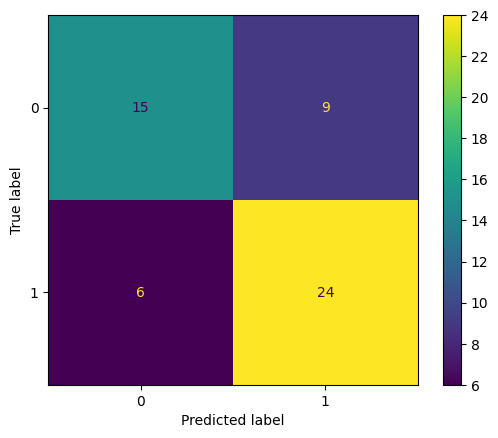

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# For manual CSV upload
from google.colab import files


# Upload CSV File
print("👉 Please upload your CSV dataset file")
uploaded = files.upload()

# Read uploaded file
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("✅ File uploaded successfully!")
print("Shape of data:", df.shape)
print(df.head())


# Detect target column (assume 'target' if present, else last column)
if "target" in df.columns:
    target_col = "target"
else:
    target_col = df.columns[-1]

print("Detected target column:", target_col)


# Split features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Convert target to numeric if needed
if y.dtype == "object":
    y = pd.factorize(y)[0]


# Identify categorical & numerical columns
numerical_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

print("Numerical:", numerical_cols)
print("Categorical:", categorical_cols)

# Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_cols),
    ("cat", cat_transformer, categorical_cols)
])


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y)) > 1 else None
)


# Baseline Model
baseline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(baseline, X_train, y_train, cv=cv, scoring="accuracy")
print("Baseline CV Accuracy: {:.4f}".format(cv_scores.mean()))


# GridSearchCV – Hyperparameter Tuning
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["liblinear", "lbfgs"]
}

gs = GridSearchCV(baseline, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters:", gs.best_params_)
print("Best CV Score:", gs.best_score_)


# Final Evaluation
best_model = gs.best_estimator_
test_acc = best_model.score(X_test, y_test)
print("Test Accuracy:", test_acc)

y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
